In [37]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PYG_GRAPHS = torch.load("data/processed/pyg_graphs_384D.pt", weights_only=False)

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8


In [38]:
## HELPER FUNCTIONS FOR CREATING AND TRAINING MODEL
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

from typing import Dict, Any, Type, Optional

def create_and_describe_model(model_args: Dict[str, Any], model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN) -> Optional[MultitaskDebateGNN]:
    """Build the model from args, print a summary, and return the instance (or None on failure)."""
    try:
        model = model_class(**model_args)
        print("Model created:")
        print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
        print(f"   Mode: {model.mode}")
        print(f"   Input dim: {model_args['in_dim']}")
        print(f"   Hidden dim: {model_args['hidden_dim']}")
        print(f"   Embedding dim: {model_args['emb_dim']}")
        print(f"   Number of layers: {model_args['num_layers']}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

        # Show model structure
        print("\nModel Structure:")
        print(model)
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def run_cv_training(
    graph_data,
    model_args: dict,
    train_args: dict,
    model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN,
    live_plot: bool = False,):
    """
    Runs cross-validation training with cleanup and plotting.
    Returns (model, results, cv_history) or (None, None, None) on failure.
    """
    import gc, traceback
    import torch

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        model, results, cv_history = train_gnn_live(
            all_graphs=getattr(graph_data, "pyg_graphs", graph_data),
            model_args=model_args,
            train_args=train_args,
            model_class=model_class,
            live_plot=live_plot,
        )
        plot_cv_losses(cv_history=cv_history)
        return model, results, cv_history
    except Exception as e:
        print(f"Training error: {e}")
        traceback.print_exc()
        return None, None, None

In [ ]:
MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    neg_attr_weight = 0.3,
    dropout = 0.15,
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, SAGEConv, ECCConv],
    ecc_kwargs=dict(
        edge_mlp_dropout=0.1,
        keep_prob=0.8,
        conf_dim=1,
        stance_dim=3
    )
)

TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    val_n_last = 1, # or val_pct_last = k (pick either one)
    # val_pct_last = 0.1,
    # val_gap_n = 1,
    task_weights = {"link": 1.0, "conf": 1.0, "stance": 1.0}
)

# See created model
_ = create_and_describe_model(MODEL_ARGS)

Model created:
   Architecture: ['SAGEConv', 'SAGEConv', 'ECCConv']
   Mode: full
   Input dim: 384
   Hidden dim: 256
   Embedding dim: 128
   Number of layers: 3

Model Statistics:
   Total parameters: 4,741,704
   Trainable parameters: 4,741,704
   Model size: ~18.1 MB

Model Structure:
MultitaskDebateGNN(
  (convs): ModuleList(
    (0): SAGEConv(384, 256, aggr=mean)
    (1): SAGEConv(256, 256, aggr=mean)
    (2): ECCConv(256, 128)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (activation): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (skip): Linear(in_features=384, out_features=128, bias=True)
  (link_head): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (edge_head): Sequential(
    (0): Linea

[gap=0] repeat 1/1 seed=42

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286

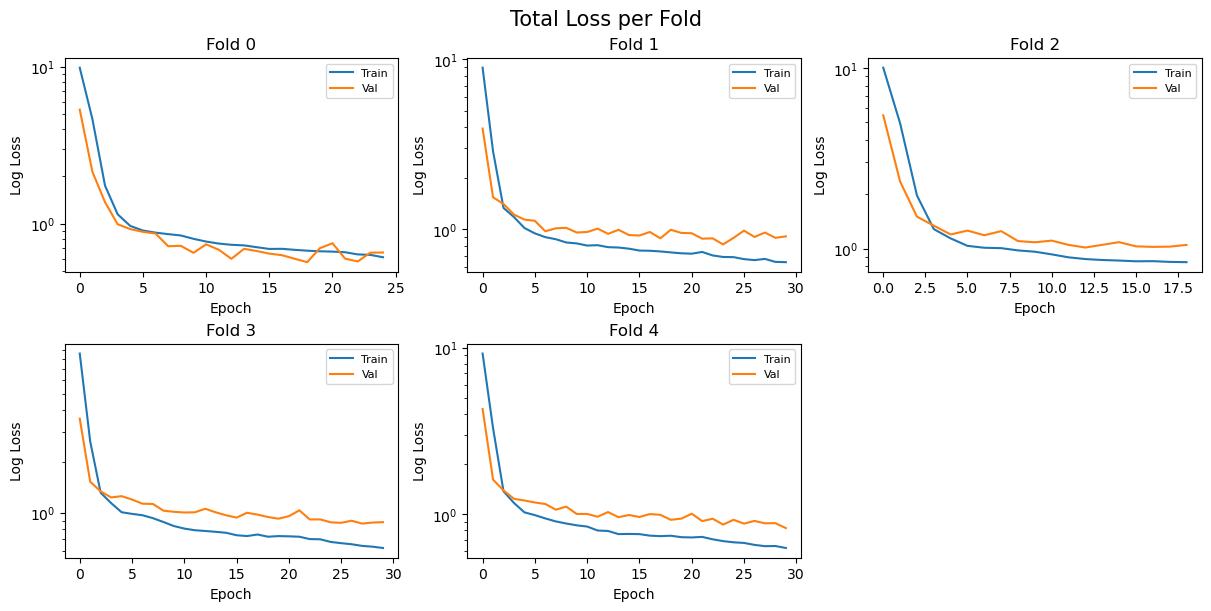

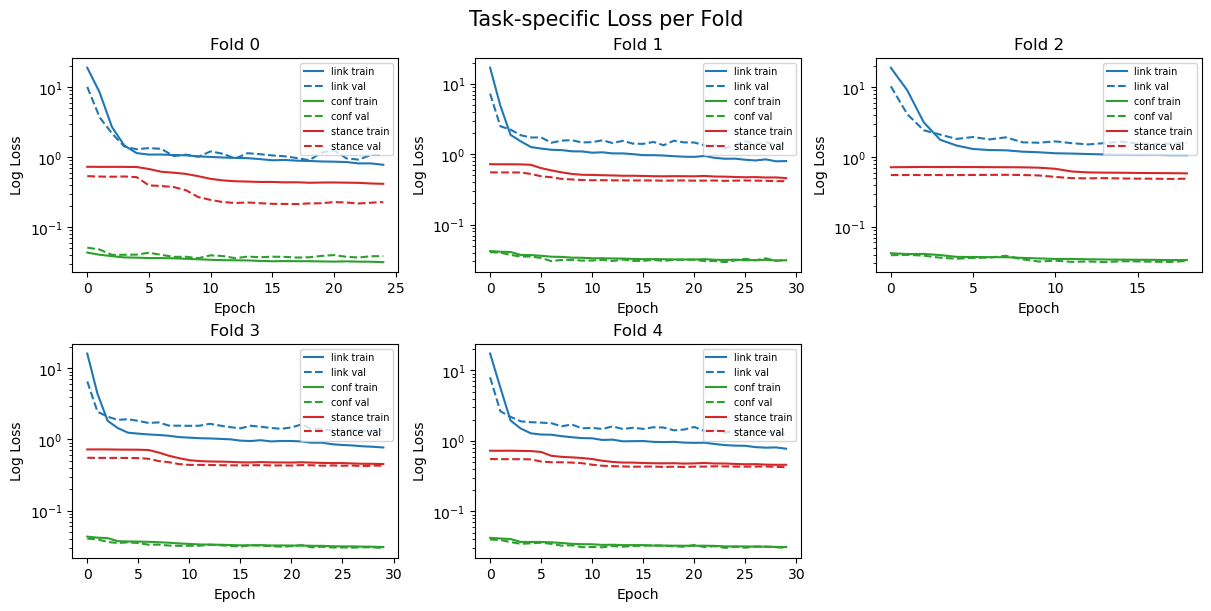

[gap=1] repeat 1/1 seed=42

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286

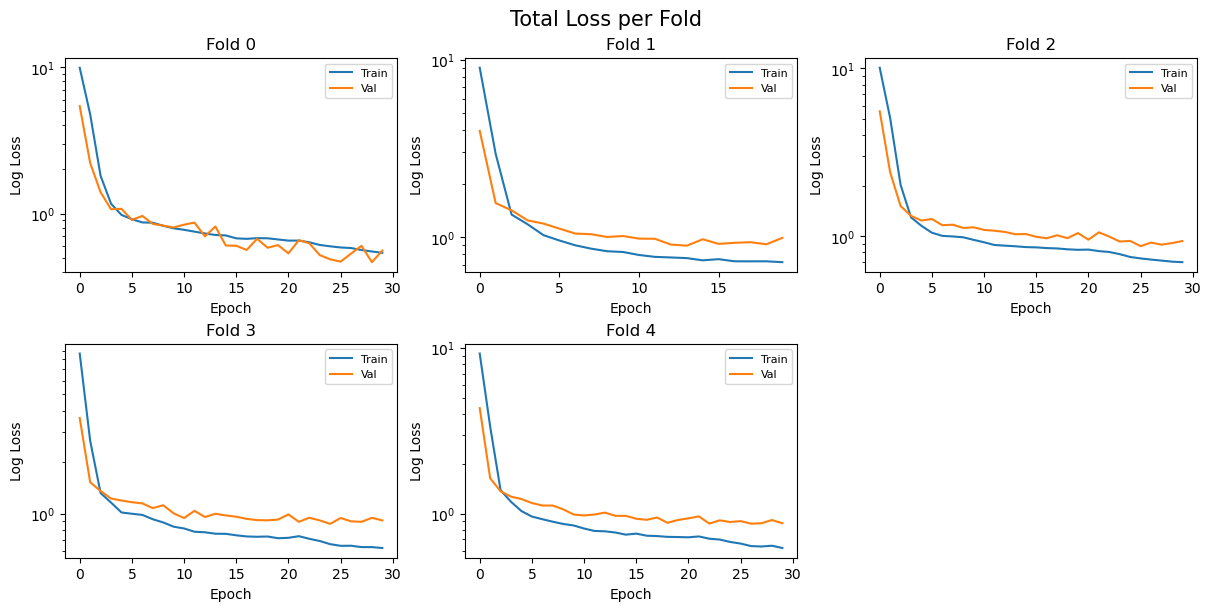

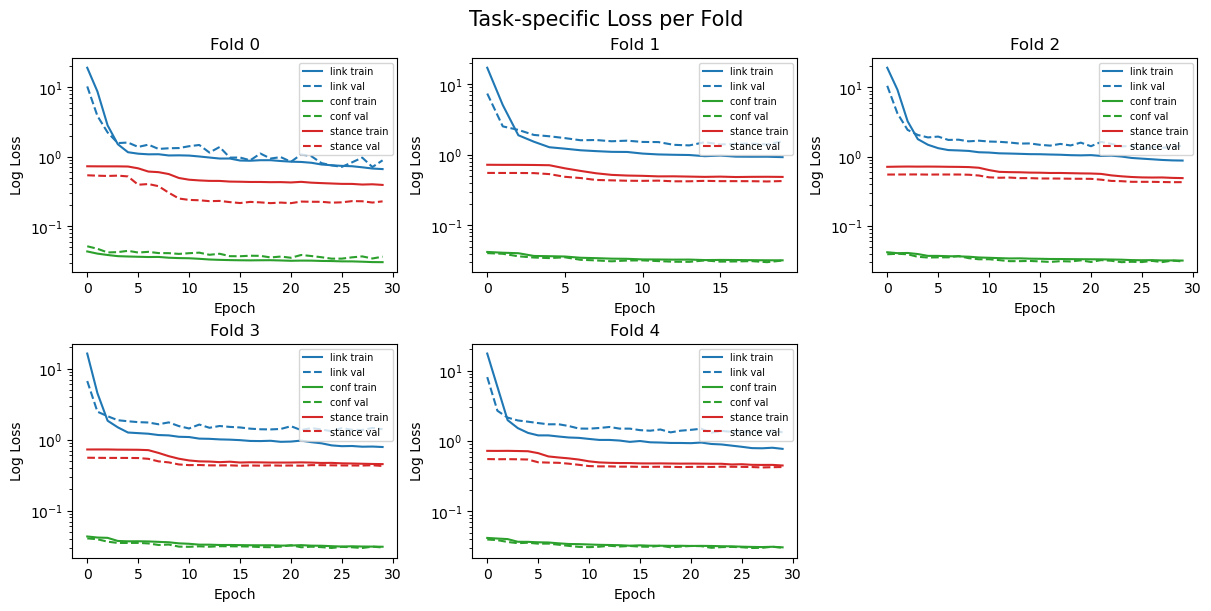

[gap=2] repeat 1/1 seed=42

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,910 nodes | 1,425 edges | Avg: 142.5 edges/graph
   + Stance Dist: [0.326, 0.225, 0.449] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,328 nodes | 4,308 edges | Avg: 165.7 edges/graph
   + Stance Dist: [0.406, 0.283, 0.311] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 6,705 nodes | 7,677 edges | Avg: 853.0 edges/graph
   + Stance Dist: [0.359, 0.214, 0.427] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,022 nodes | 7,296 edges | Avg: 810.7 edges/graph
   + Stance Dist: [0.402, 0.245, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,251
  - Total edges: 35,286

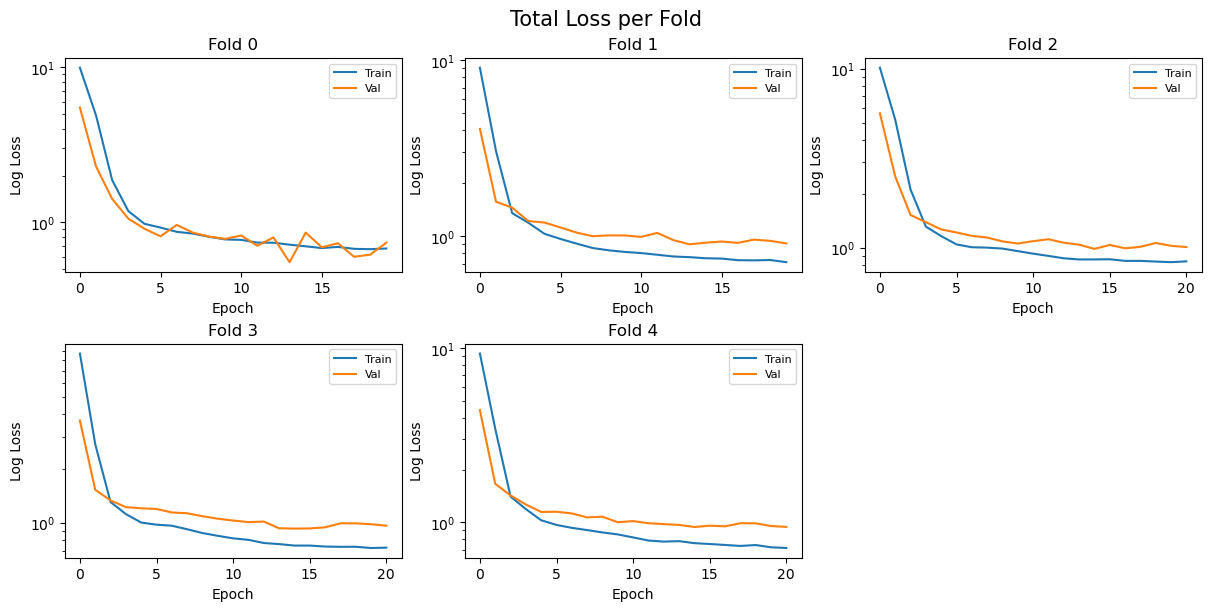

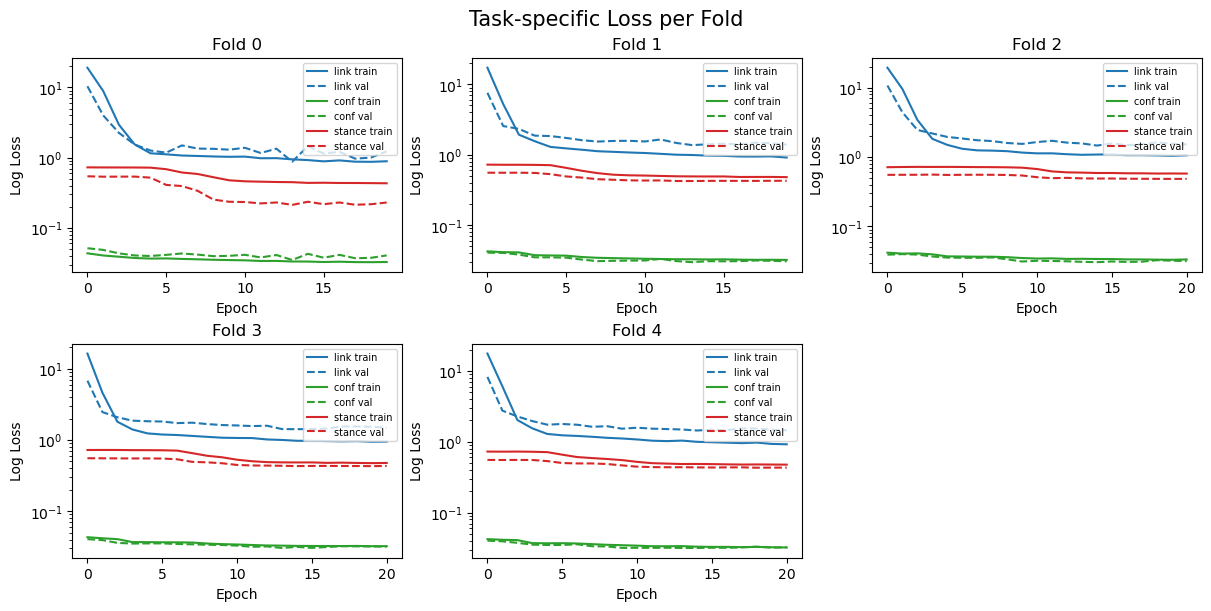


Gap ablation — test metrics (means across folds & repeats):


,gap,conf_mae_mean,conf_nll_mean,link_auc_mean,stance_kl_mean,stance_nll_mean
0,0,0.3455,0.7121,0.8762,0.6158,0.6237
1,1,0.3453,0.7144,0.8927,0.5898,0.5977
2,2,0.3438,0.7242,0.8492,0.6302,0.6381


Saved summary CSV to: results/gap_ablation_test_means.csv


In [ ]:
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from copy import deepcopy

def gap_ablation_test_means(
    gaps,
    repeats=1,
    train_args_base=None,
    model_args=None,
    graph_data=None,
    seed_base=42,
    save_csv="results/gap_ablation_test_means.csv",
):
    """
    Run gap ablation, average test metrics across folds and repeats.
    Produces a table with per-gap metric means.
    """
    assert train_args_base is not None and model_args is not None and graph_data is not None

    records = {g: defaultdict(list) for g in gaps}

    for g in gaps:
        for r in range(repeats):
            seed = seed_base + r
            np.random.seed(seed)
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

            ta = deepcopy(train_args_base)
            ta["val_gap_n"] = int(g)
            print(f"[gap={g}] repeat {r+1}/{repeats} seed={seed}")
            _, results, _ = run_cv_training(
                graph_data=graph_data,
                model_args=model_args,
                train_args=ta,
                model_class=MultitaskDebateGNN,
                live_plot=False,
            )

            if not results:
                # preserve repeat count by recording NaNs
                continue

            all_fold_dicts = list(results.values()) if isinstance(results, dict) else list(results)
            metric_names = sorted({k for d in all_fold_dicts for k in d.keys()})
            for m in metric_names:
                vals = [d.get(m, np.nan) for d in all_fold_dicts]
                vals = [float(x) for x in vals if x is not None]
                mean_across_folds = np.nan if len(vals) == 0 else float(np.nanmean(vals))
                records[g][m].append(mean_across_folds)

    # build DataFrame with mean across repeats (no std)
    rows = []
    all_metrics = sorted({m for rec in records.values() for m in rec.keys()})
    for g in gaps:
        row = {"gap": g}
        for m in all_metrics:
            arr = np.array(records[g].get(m, []), dtype=float)
            mean_over_repeats = float(np.nan) if arr.size == 0 else float(np.nanmean(arr))
            row[f"{m}_mean"] = mean_over_repeats
        rows.append(row)

    df = pd.DataFrame(rows).sort_values("gap").reset_index(drop=True)
    pd.options.display.float_format = "{:0.4f}".format
    print("\nGap ablation — test metrics (means across folds & repeats):")
    display(df)

    try:
        df.to_csv(save_csv, index=False)
        print(f"Saved summary CSV to: {save_csv}")
    except Exception as e:
        print(f"Could not save CSV: {e}")

    return df, records

# Run and save results
df_means, raw = gap_ablation_test_means(
    gaps=[0,1,2], repeats=1, train_args_base=TRAIN_ARGS, model_args=MODEL_ARGS, graph_data=PYG_GRAPHS)


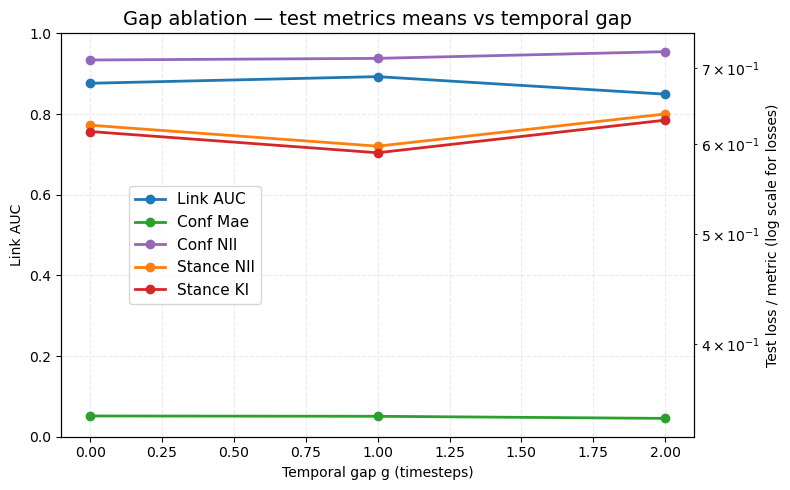

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if 'df_means' not in globals():
    raise RuntimeError("df_means not found. Run gap_ablation_test_means(...) first to produce df_means.")

df = df_means.copy()
gaps = df['gap'].values

# Find metric mean columns and prefer canonical order if present
preferred = ['link_auc', 'conf_mae','conf_nll',  'stance_nll', 'stance_mae']
mean_cols = {col[:-5]: col for col in df.columns if col.endswith('_mean') and col != 'gap'}
ordered_metrics = [m for m in preferred if m in mean_cols] + [m for m in mean_cols.keys() if m not in preferred]

# Prepare values
vals = {m: df[mean_cols[m]].values for m in ordered_metrics}

# Use more distinct colors
color_map = {
    'link_auc': 'tab:blue',
    'conf_mae': 'tab:green',
    'stance_nll': 'tab:orange',
    'conf_nll': 'tab:purple',
    'stance_mae': 'tab:red'
}
default_colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red', 'tab:pink', 'tab:gray']

fig, ax1 = plt.subplots(figsize=(8,5))

# Plot Link AUC on left axis
if 'link_auc' in vals:
    ax1.plot(gaps, vals['link_auc'], marker='o', color=color_map.get('link_auc', default_colors[0]), label='Link AUC', linewidth=2)
    ax1.set_ylim(0.0, 1.0)
    ax1.set_ylabel('Link AUC', fontsize=10)
    ax1.tick_params(axis='y')

# Plot other metrics on right axis
ax2 = ax1.twinx()
loss_metrics = [m for m in ordered_metrics if m != 'link_auc']
for i, m in enumerate(loss_metrics):
    ax2.plot(
        gaps,
        vals[m],
        marker='o',
        color=color_map.get(m, default_colors[i+1]),
        label=m.replace('_',' ').title(),
        linewidth=2
    )
ax2.set_ylabel('Test loss / metric (log scale for losses)', color='black')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='black')

# Combined legend in the center of the plot box
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='center',
    bbox_to_anchor=(0.25, 0.5),
    fontsize=11,
    frameon=True
)

ax1.set_xlabel('Temporal gap g (timesteps)')
plt.title('Gap ablation — test metrics means vs temporal gap', fontsize=14)
ax1.grid(True, alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()

# optional save figure
# fig.savefig("results/gap_ablation_test_metrics_means.png", dpi=150)